# Advanced Obesity Level Classification
This notebook implements an advanced ensemble model for obesity level classification using Random Forest and Gradient Boosting classifiers.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preprocessing
First, we'll load the dataset and preprocess it by encoding categorical variables and scaling numerical features.

In [2]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['Gender', 'CALC', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS', 'family_history_with_overweight']
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # Convert numeric columns
    numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
    
    # Split features and target
    X = df.drop('NObeyesdad', axis=1)
    y = df['NObeyesdad']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, df

# Load the data
X, y, df = load_and_preprocess_data('dataset.csv')
print('Data shape:', X.shape)
print('Target value counts:', pd.Series(y).value_counts())

Data shape: (2111, 16)
Target value counts: NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


## Create and Train the Ensemble Model
We'll create an ensemble model combining Random Forest and Gradient Boosting classifiers.

In [3]:
def create_ensemble_model():
    rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    
    ensemble = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('gb', gb)
        ],
        voting='soft'
    )
    
    return ensemble

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Create and train ensemble model
model = create_ensemble_model()
model.fit(X_train_balanced, y_train_balanced)

/Users/shivamdubey/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42))],
                 voting='soft')

## Model Evaluation
Let's evaluate the model's performance using various metrics and visualizations.

In [4]:
# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})')

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.97        56
      Normal_Weight       0.95      0.85      0.90        62
     Obesity_Type_I       0.99      0.95      0.97        78
    Obesity_Type_II       0.95      0.98      0.97        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.88      0.93      0.90        56
Overweight_Level_II       0.98      0.98      0.98        50

           accuracy                           0.96       423
          macro avg       0.95      0.96      0.95       423
       weighted avg       0.96      0.96      0.95       423

Cross-validation scores: [0.80851064 0.98578199 0.98578199 0.97630332 0.98341232]
Average CV score: 0.948 (+/- 0.140)


## Visualize Results
Let's create some visualizations to better understand the model's performance.

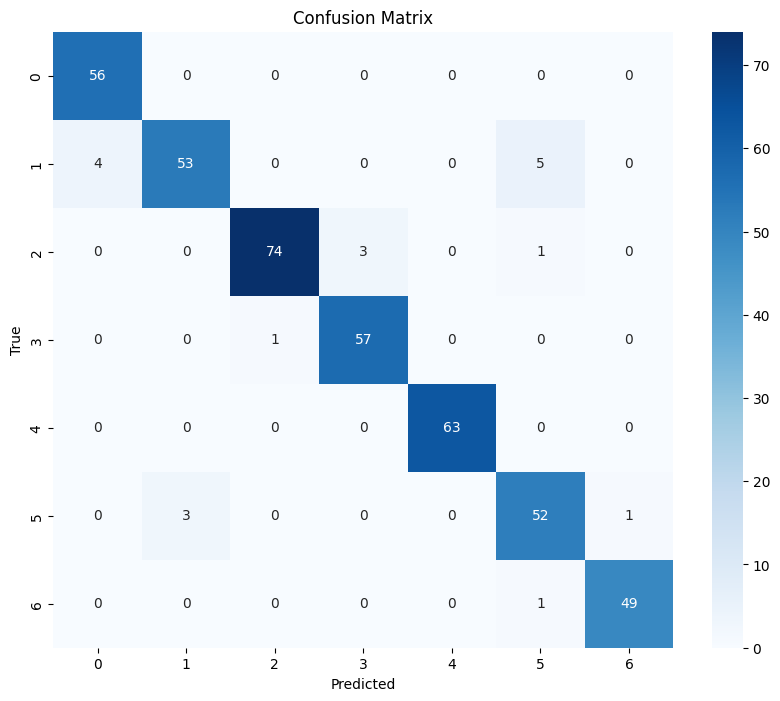

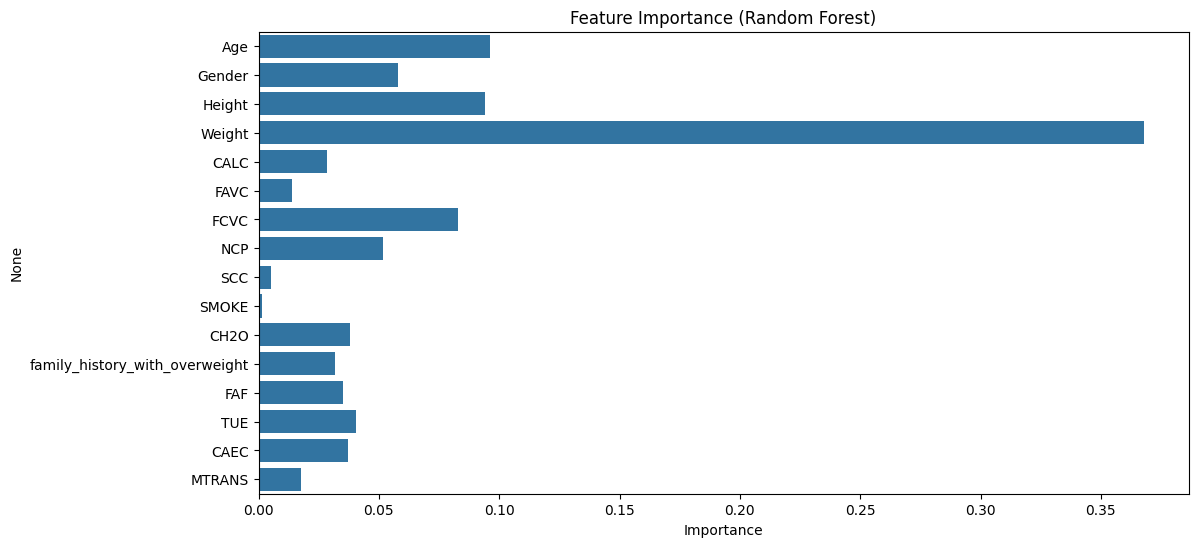

In [5]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot feature importance
feature_importance = model.estimators_[0].feature_importances_
feature_names = df.drop('NObeyesdad', axis=1).columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.show()